In [1]:
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms import QSVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import svm

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

2022-04-08 17:16:30.564825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-08 17:16:30.564860: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Confusion Matrix Calculation

In [2]:
def confusion_matrix(y_pred, y_true, percent = True, display = False, labels = None):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    vals = np.unique(y_true)
    vals[::-1].sort() # largest values show up first in confusion matrix
    n = len(vals)
    mat = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            mat[i, j] = sum((y_true == vals[i]) & (y_pred == vals[j]))
    if percent:
        mat = mat/np.sum(mat, axis = 1, keepdims = True)
    
    if display:
        if labels is None:
            labels = vals
        _, ax = plt.subplots()
        plt.ylabel("actual")
        plt.xlabel("predicted")
        ax.matshow(mat, cmap=plt.cm.Blues)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.xaxis.set_ticks(range(n))
        ax.yaxis.set_ticks(range(n))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        for i in range(mat.shape[0]):
            for j in range(mat.shape[0]):
                ax.text(i, j, str(mat[j,i]), va='center', ha='center')
        plt.show()
    return mat

In [3]:
def ROC(y_train_score1, y_test_score1, y_train, y_test):
    falsePos1, truePos1, _ = roc_curve(y_train, y_train_score1)
    roc_auc1 = auc(falsePos1, truePos1)

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
    ax1.plot(falsePos1, truePos1, label='SVM $\gamma = 5$', color='b')
    ax1.set_title('Training Data')

    falsePos2, truePos2, _ = roc_curve(y_test, y_test_score1)
    roc_auc1 = auc(falsePos2, truePos2)
    ax2.plot(falsePos2, truePos2, label='SVM $\gamma = 5$', color='b')

    ax2.set_title('Test Data')

    for ax in fig.axes:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([-0.05, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")

In [4]:
# Direct Kernel Set Training Data
dks_train_1 = pd.read_csv('data/Direct_Kernel_Set_I_Training.csv')

# Direct Kernel Set Classifcation Data
dks_class_1 = pd.read_csv('data/Direct_Kernel_Set_I_Classifications.csv')

x1_train = dks_class_1.iloc[:, 1:3]
y1_train = dks_class_1.iloc[:, 3]

x1_test = dks_train_1.iloc[:, 1:3]
y1_test = dks_train_1.iloc[:, 3]

In [5]:
x2_train, y2_train, x2_test, y2_test = ad_hoc_data(training_size = 80, test_size = 20, n=2, gap = 0.2, one_hot = False)

In [6]:
(x3_train, y3_train), (x3_test, y3_test) = keras.datasets.mnist.load_data()
x3_train = x3_train.reshape((60000, 28*28))
x3_test = x3_test.reshape((-1, 28*28))
x3_train.shape
num_dims = 10
#idx = list(range(0, 28*28, int(28*28 / num_dims) + 1))
#x3_train[:10, idx]

def limit_data(x, y, nums):
    idx = (y != y)
    for i in nums:
        idx = idx | (y == i)
    return x[idx], y[idx]

x3_train, y3_train = limit_data(x3_train, y3_train, [3, 6])
x3_test, y3_test = limit_data(x3_test, y3_test, [3, 6])
y3_train = (y3_train == 3).astype(int)
y3_test = (y3_test == 3).astype(int)

scaler = StandardScaler().fit(x3_train)
x3_train = scaler.transform(x3_train)
x3_test = scaler.transform(x3_test)

pca = PCA(n_components=num_dims).fit(x3_train)
x3_train = pca.transform(x3_train)
x3_test = pca.transform(x3_test)
print(pca.explained_variance_ratio_)

samples = np.append(x3_train, x3_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
x3_train = minmax_scale.transform(x3_train)
x3_test = minmax_scale.transform(x3_test)

[0.08939126 0.05811813 0.04367666 0.02961372 0.02748219 0.02472023
 0.01852857 0.01558116 0.01492141 0.01388878]


In [7]:
random_seed = 10598
feature_map = ZZFeatureMap(feature_dimension=2,
                                 reps=2, entanglement='full')
backend = QuantumInstance(BasicAer.get_backend('statevector_simulator'), shots=1,
                                seed_simulator=random_seed, seed_transpiler=random_seed)
kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

qsvc = QSVC(quantum_kernel=kernel)
start_time = time.time()
qsvc.fit(x1_train, y1_train)#train
train_time = time.time() - start_time
y1_pred = qsvc.predict(x1_test) #predict
test_time = time.time() - start_time - train_time
print ("Direct kernel set QSVM")
print ("Training time:{0}".format(train_time) + "[sec]")
print ("Test time:{0}".format(test_time) + "[sec]")

Direct kernel set QSVM
Training time:2.184183120727539[sec]
Test time:0.8104088306427002[sec]


Direct kernel set QSVM


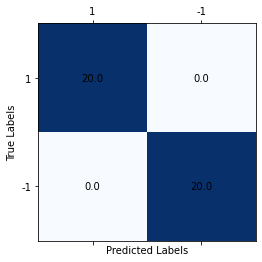

array([[20.,  0.],
       [ 0., 20.]])

In [8]:
print("Direct kernel set QSVM")
confusion_matrix(y1_pred, y1_test, False, True)

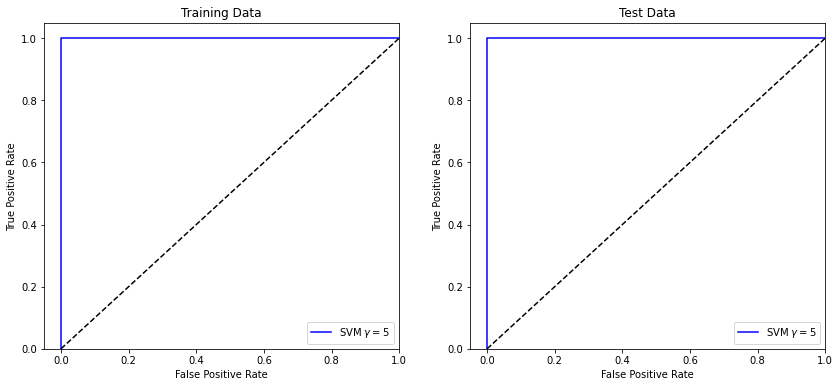

In [9]:
y_train_score1 = qsvc.decision_function(x1_train)
y_test_score1 = qsvc.decision_function(x1_test)

ROC(y_train_score1, y_test_score1, y1_train, y1_test)

In [10]:
svm1 = svm.SVC(C = 5, kernel = "rbf", gamma = 5)
start_time = time.time()
svm1.fit(x1_train, y1_train) # train
train_time = time.time() - start_time
y1_pred = svm1.predict(x1_test) #predict
test_time = time.time() - start_time - train_time
print ("Direct kernel set classical SVM")
print ("Training time:{0}".format(train_time) + "[sec]")
print ("Test time:{0}".format(test_time) + "[sec]")

Direct kernel set classical SVM
Training time:0.005202054977416992[sec]
Test time:0.001188516616821289[sec]


Direct kernel set classical SVM


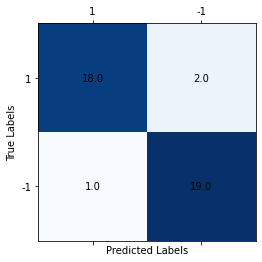

array([[18.,  2.],
       [ 1., 19.]])

In [11]:
print ("Direct kernel set classical SVM")
confusion_matrix(y1_pred, y1_test, False, True)

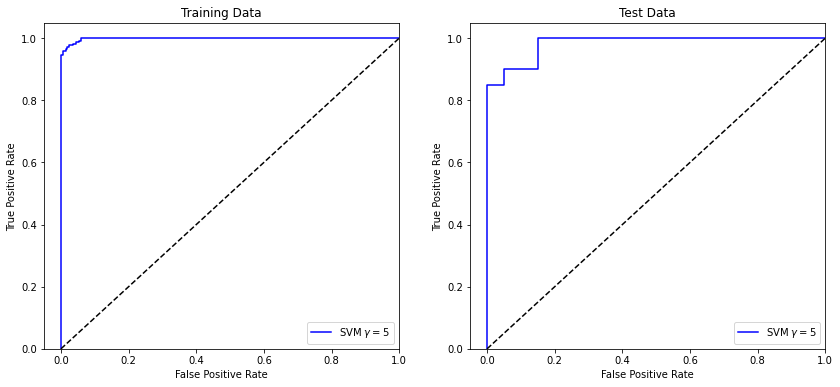

In [12]:
y_train_score1 = svm1.decision_function(x1_train)
y_test_score1 = svm1.decision_function(x1_test)

ROC(y_train_score1, y_test_score1, y1_train, y1_test)

In [13]:
# Second dataset (ad hoc data)
random_seed = 10598
feature_map = ZZFeatureMap(feature_dimension=2,
                                 reps=2, entanglement='full')
backend = QuantumInstance(BasicAer.get_backend('statevector_simulator'), shots=1,
                                seed_simulator=random_seed, seed_transpiler=random_seed)
kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

qsvc = QSVC(quantum_kernel=kernel)
start_time = time.time()
qsvc.fit(x2_train, y2_train)#train
train_time = time.time() - start_time
y2_pred = qsvc.predict(x2_test) #predict
test_time = time.time() - start_time - train_time
print("Ad hoc dataset QSVM")
print ("Training time:{0}".format(train_time) + "[sec]")
print ("Test time:{0}".format(test_time) + "[sec]")

Ad hoc dataset QSVM
Training time:0.5268135070800781[sec]
Test time:0.3193352222442627[sec]


Ad hoc dataset QSVM


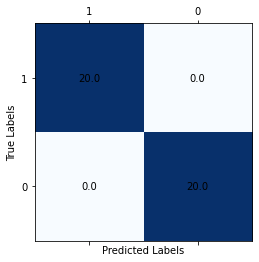

array([[20.,  0.],
       [ 0., 20.]])

In [14]:
print("Ad hoc dataset QSVM")
confusion_matrix(y2_pred, y2_test, False, True)

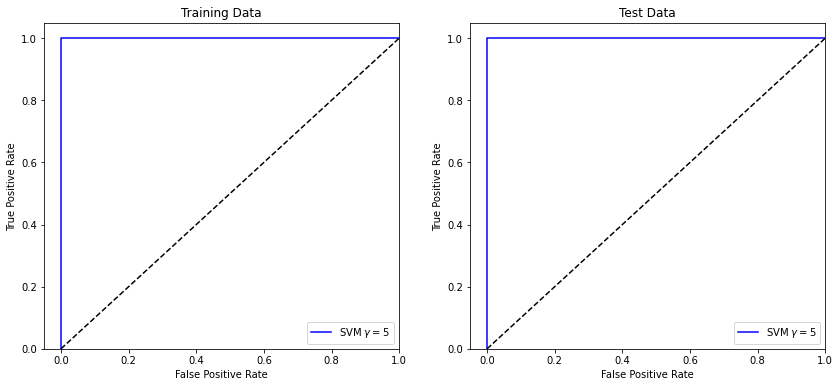

In [15]:
y_train_score2 = qsvc.decision_function(x2_train)
y_test_score2 = qsvc.decision_function(x2_test)

ROC(y_train_score2, y_test_score2, y2_train, y2_test)

In [16]:
svm2 = svm.SVC(C = 5, kernel = "rbf", gamma = 5)
start_time = time.time()
svm2.fit(x2_train, y2_train) # train
train_time = time.time() - start_time
y2_pred = svm2.predict(x2_test) #predict
test_time = time.time() - start_time - train_time
print("Ad hoc dataset Classical SVM")
print ("Training time:{0}".format(train_time) + "[sec]")
print ("Test time:{0}".format(test_time) + "[sec]")

Ad hoc dataset Classical SVM
Training time:0.0015406608581542969[sec]
Test time:0.0003123283386230469[sec]


Ad hoc dataset Classical SVM


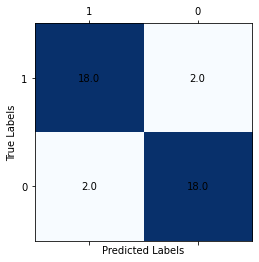

array([[18.,  2.],
       [ 2., 18.]])

In [17]:
print("Ad hoc dataset Classical SVM")
confusion_matrix(y2_pred, y2_test, False, True)

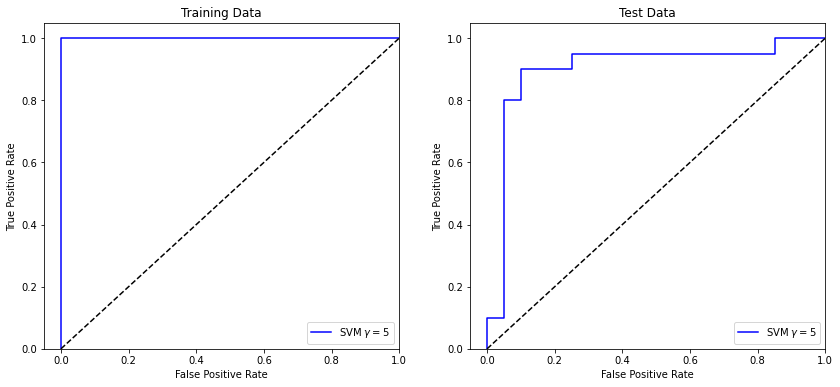

In [18]:
y_train_score2 = svm2.decision_function(x2_train)
y_test_score2 = svm2.decision_function(x2_test)

ROC(y_train_score2, y_test_score2, y2_train, y2_test)

In [19]:
# Third dataset (mnist dataset)
random_seed = 10598
feature_map = ZZFeatureMap(feature_dimension=num_dims,
                                 reps=1, entanglement='full')
backend = QuantumInstance(BasicAer.get_backend('statevector_simulator'), shots=1,
                                seed_simulator=random_seed, seed_transpiler=random_seed)
kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

qsvc = QSVC(quantum_kernel=kernel)
start_time = time.time()
qsvc.fit(x3_train[:100], y3_train[:100])#train
train_time = time.time() - start_time
y3_pred = qsvc.predict(x3_test[:50]) #predict
test_time = time.time() - start_time - train_time
print("mnist dataset QSVM")
print ("Training time:{0}".format(train_time) + "[sec]")
print ("Test time:{0}".format(test_time) + "[sec]")

mnist dataset QSVM
Training time:2.366288185119629[sec]
Test time:3.343956708908081[sec]


mnist dataset QSVM


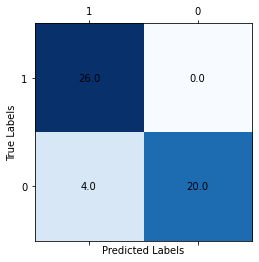

array([[26.,  0.],
       [ 4., 20.]])

In [20]:
print("mnist dataset QSVM")
confusion_matrix(y3_pred, y3_test[:50], False, True)

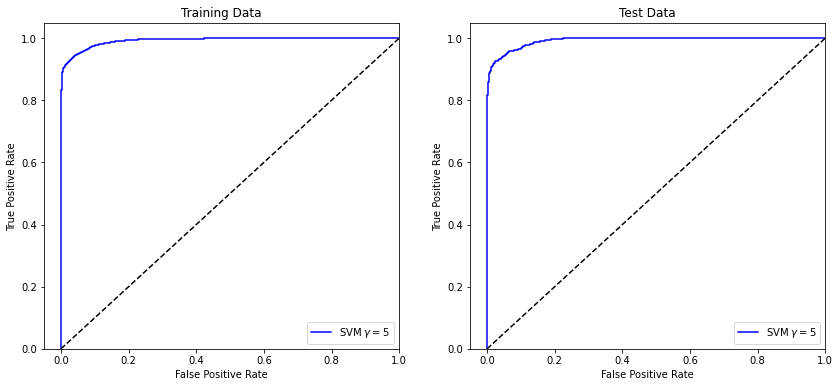

In [21]:
y_train_score3 = qsvc.decision_function(x3_train)
y_test_score3 = qsvc.decision_function(x3_test)

ROC(y_train_score3, y_test_score3, y3_train, y3_test)

In [22]:
svm3 = svm.SVC(C = 5, kernel = "rbf", gamma = 5)
start_time = time.time()
svm3.fit(x3_train, y3_train) # train
train_time = time.time() - start_time
y3_pred = svm3.predict(x3_test) #predict
test_time = time.time() - start_time - train_time
print("mnist dataset Classical SVM")
print ("Training time:{0}".format(train_time) + "[sec]")
print ("Test time:{0}".format(test_time) + "[sec]")

mnist dataset Classical SVM
Training time:0.2232820987701416[sec]
Test time:0.04427790641784668[sec]


mnist dataset Classical SVM


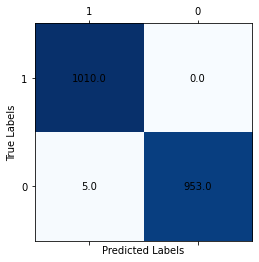

array([[1010.,    0.],
       [   5.,  953.]])

In [23]:
print("mnist dataset Classical SVM")
confusion_matrix(y3_pred, y3_test, False, True)

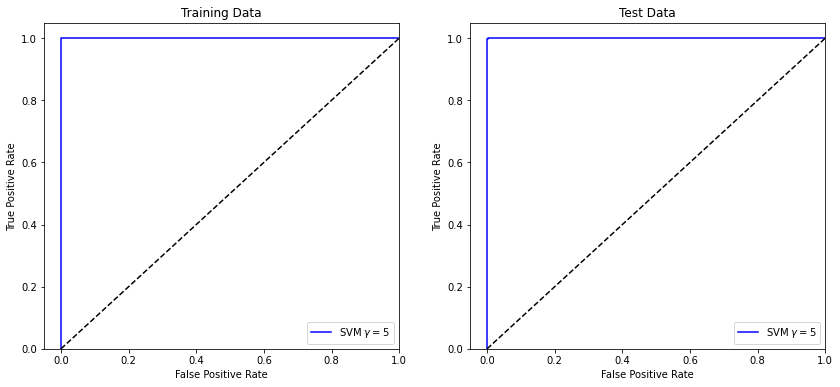

In [24]:
y_train_score3 = svm3.decision_function(x3_train)
y_test_score3 = svm3.decision_function(x3_test)

ROC(y_train_score3, y_test_score3, y3_train, y3_test)